In [1]:
# | code-summary: code -- load dependencies and data and specify analysis parameters

from compmemlearn.fitting import generate_objective_function, apply_and_concatenate
from compmemlearn.datasets import simulate_df
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import importlib

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

section_introduction = """
## Simulation of Penn Electrophysiology of Encoding and Retrieval Study (PEERS)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the PEERS dataset reported by . Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-{section_tag}Fits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration.
"""

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in PEERS dataset under each considered model."""

section_tag = "PEERS"

data_path = "../data/PEERS.csv"
data_query = "task == -1 & session != 0"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR"]

free_parameters = [
    [
        'encoding_drift_rate',
        'start_drift_rate',
        'recall_drift_rate',
        'shared_support',
        'item_support',
        'learning_rate',
        'primacy_scale',
        'primacy_decay',
        'stop_probability_scale',
        'stop_probability_growth',
        'choice_sensitivity',
        'delay_drift_rate'
    ],
        [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        'choice_sensitivity',
        #    "context_sensitivity",
        #    "feature_sensitivity",
        "delay_drift_rate",
    ]
]

bounds = [
    [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
    ],
        [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"context_sensitivity": 1, "feature_sensitivity": 1},
]


In [2]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

# load dataset and extract key metadata
events = pd.read_csv(data_path).query(data_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
        events,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        cost_function(x)

In [3]:
#| echo: false
#| input: false
#| output: asis

print(section_introduction.format(section_tag=section_tag))


## Simulation of Penn Electrophysiology of Encoding and Retrieval Study (PEERS)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the PEERS dataset reported by . Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset pr

In [4]:
#| code-summary: code -- 1) fit models to entire dataset rather than participant-by-participant
#| output: false

fit_result = []
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    cost_function = generate_objective_function(
            events,
            init_model,
            fixed_parameters[model_index],
            free_parameters[model_index],
        )

    fit_result.append(
        differential_evolution(
            cost_function, bounds[model_index], disp=True
        ))
    print(fit_result[-1])

differential_evolution step 1: f(x)= 190260
differential_evolution step 2: f(x)= 150512
differential_evolution step 3: f(x)= 150512
differential_evolution step 4: f(x)= 150512
differential_evolution step 5: f(x)= 147774
differential_evolution step 6: f(x)= 147774
differential_evolution step 7: f(x)= 147774
differential_evolution step 8: f(x)= 125472
differential_evolution step 9: f(x)= 125472
differential_evolution step 10: f(x)= 125472
differential_evolution step 11: f(x)= 125472
differential_evolution step 12: f(x)= 125472
differential_evolution step 13: f(x)= 125472
differential_evolution step 14: f(x)= 125472
differential_evolution step 15: f(x)= 120882
differential_evolution step 16: f(x)= 120882
differential_evolution step 17: f(x)= 120882
differential_evolution step 18: f(x)= 120882
differential_evolution step 19: f(x)= 120882
differential_evolution step 20: f(x)= 120882
differential_evolution step 21: f(x)= 120882
differential_evolution step 22: f(x)= 119825
differential_evolut

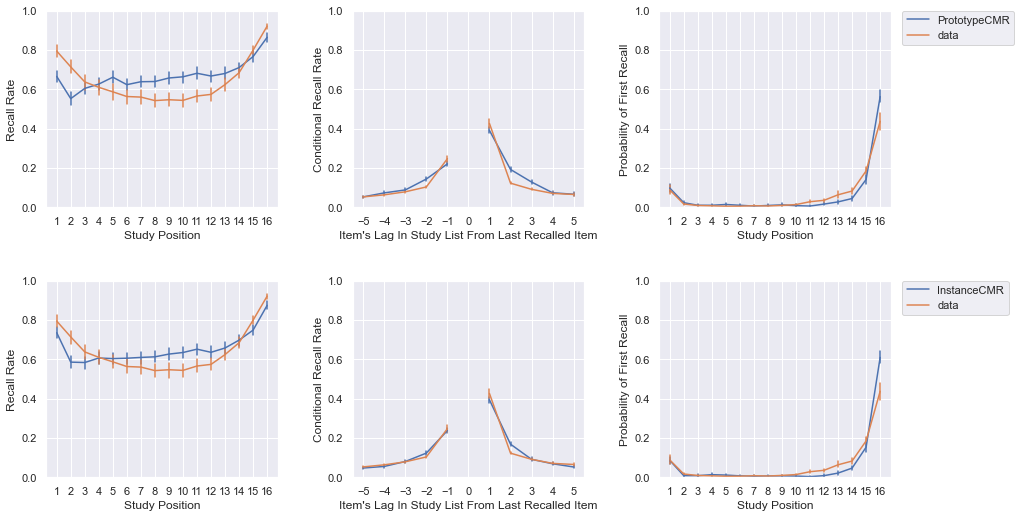

In [5]:
# | output: false
# | code-summary: code -- 2) compose simulated spc, lag-crp, pfr from overall fitting results

sns.set(style='darkgrid')

if 'list length' in events.columns:
    list_lengths = List([int(each) for each in pd.unique(events["list length"])])
else:
    list_lengths = List([int(np.max(events.input))])

for list_length in list_lengths:

    fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False) 
    for model_index, model_class in enumerate(models):

        fitted_parameters = Dict.empty(
            key_type=types.unicode_type, value_type=types.float64
        )
        for i in range(len(fit_result[model_index].x)):
            fitted_parameters[free_parameters[model_index][i]] = fit_result[model_index].x[i]
        for key in fixed_parameters[model_index]:
            fitted_parameters[key] = fixed_parameters[model_index][key]

        model = model_class(list_length, list_length, fitted_parameters)

        sim_df = simulate_df(model, 1000)

        if len(list_lengths) > 1:
            true_df = events.query(f'`list length` == {list_length}')
        else:
            true_df = events.copy()

        sim_spc = apply_and_concatenate(
                fr.spc,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )

        sim_lag_crp = apply_and_concatenate(
                fr.lag_crp,
                sim_df,
                true_df,
                "source",
                labels=[model_names[model_index], "data"],
            )

        sim_pfr = apply_and_concatenate(
                fr.pnr,
                sim_df,
                true_df,
                contrast_name="source",
                labels=[model_names[model_index], "data"],
            )
        sim_pfr = sim_pfr.query("output <= 1")

        # serial position curve
        sns.lineplot(ax=axes[model_index, 0], data=sim_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
        axes[model_index, 0].set(xlabel='Study Position', ylabel='Recall Rate')
        axes[model_index, 0].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 0].set_ylim((0, 1))

        # lag crp curve
        max_lag = 5
        filt_neg = f'{-max_lag} <= lag < 0'
        filt_pos = f'0 < lag <= {max_lag}'

        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_neg), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        sns.lineplot(ax=axes[model_index, 1], data=sim_lag_crp.query(filt_pos), x='lag', y='prob', 
                    err_style='bars', hue='source', legend=False)
        axes[model_index, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
        axes[model_index, 1].set_xticks(np.arange(-5, 6, 1))
        axes[model_index, 1].set_ylim((0, 1))


        # pfr
        sns.lineplot(data=sim_pfr, x='input', y='prob', err_style='bars', ax=axes[model_index, 2], hue='source')
        axes[model_index, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
        axes[model_index, 2].set_xticks(np.arange(1, list_length+int(list_length/10), int(list_length/10)))
        axes[model_index, 2].set_ylim((0, 1))

        # set legend of axis 2 outside the plot, to the right
        axes[model_index, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout(pad=3)
    plt.savefig(f'overall_{section_tag}_length_{list_length}.pdf', bbox_inches='tight')